This notebook presents exploratory data analysis of the health claim dataset.

# Project set up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
from create_data_partitions import create_train_test, create_claim_train_test

In [2]:
sns.set()

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.3}'.format)

In [4]:
pd.__version__

'2.2.3'

# Load Dataset

## Coverages

In [5]:
cvg = pd.read_csv('../DATA/CI_CVGS.csv')

In [6]:
#Some columns of the dataset are private
display_cols_cvg = ['CLAIM', 'START_AGE', 'TENURE', 'MATURITY_AGE', 'TIME_TO_MATURE', 
                    'SEX_CD', 'SUM_INSURED', 'SMOKER', 'MARITAL_STATUS', 'INCOME', 'YEARS_EMPLOYED']

In [7]:
cvg.loc[:, display_cols_cvg].head()

,CLAIM,START_AGE,TENURE,MATURITY_AGE,TIME_TO_MATURE,SEX_CD,SUM_INSURED,SMOKER,MARITAL_STATUS,INCOME,YEARS_EMPLOYED
0,0,42,149,70,10078,M,1e+05,0,UNKNOWN,5000,13
1,0,36,303,65,10289,M,1e+05,0,UNKNOWN,12000,1
2,0,28,918,65,12596,F,1e+06,0,UNKNOWN,0,0
3,0,33,3291,65,8397,M,2.5e+05,0,MARRIED,1666,6
4,0,40,728,65,8403,F,2.5e+05,0,MARRIED,8333,10


In [8]:
#Convert columns to datetime format
cols = ['START_DT', 'END_DT', 'DOB', 'MATURITY_DT']
for col in cols:
    cvg.loc[:, col] = pd.to_datetime(cvg[col])

In [9]:
#Convert columns to appropriate formats, prevent pandas nullable types as these are incompatible with sci-kit
cvg = cvg.convert_dtypes(convert_floating=False, convert_integer=False)

## Claims

In [10]:
claims = pd.read_csv('../DATA/HEALTH_CLAIMS.csv')

In [11]:
#Some columns of the dataset are private
display_cols_claims = ['CLAIM_ID', 'CLAIM_PROCEDURE_ID', 'PROCEDURE_CODE', 'PROCEDURE_GROUP', 
                       'CLAIM_DIAGNOSIS_ID', 'DIAGNOSIS_CODE', 'DIAGNOSIS_GROUP', 
                       'CHARGES', 'CLAIM_LENGTH', 'PROCEDURE_LENGTH', 'EOB_CATEGORY', 'STATUS', 'PROCEDURE_STATUS', 'CLAIM_DT']

In [12]:
claims.loc[:, display_cols_claims].head()

,CLAIM_ID,CLAIM_PROCEDURE_ID,PROCEDURE_CODE,PROCEDURE_GROUP,CLAIM_DIAGNOSIS_ID,DIAGNOSIS_CODE,DIAGNOSIS_GROUP,CHARGES,CLAIM_LENGTH,PROCEDURE_LENGTH,EOB_CATEGORY,STATUS,PROCEDURE_STATUS,CLAIM_DT
0,2525285,5642243,D1110,DENTAL,3120020,Z01.20,DENTAL,4.8e+02,0.0,0,4_PASS,CLOSED,APP,2021-12-10
1,2525285,5642242,D0120,DENTAL,3120020,Z01.20,DENTAL,2.3e+02,0.0,0,4_PASS,CLOSED,APP,2021-12-10
2,2525285,5642244,D0274,DENTAL,3120020,Z01.20,DENTAL,1.8e+02,0.0,0,5_NONE,CLOSED,APP,2021-12-10
3,1313265,2848966,99201,VISIT,1604812,611.72,CANCER/GROWTH,2.7e+02,0.0,0,4_PASS,CLOSED,DENY,2016-05-23
4,1313266,2848969,80048,TEST,1604813,611.72,CANCER/GROWTH,5e+02,0.0,0,4_PASS,CLOSED,DENY,2016-05-23


In [13]:
print('Size of dataset: ', claims.shape)
print('Number of unique clients: ', claims['MDM_ID'].nunique())
print('Number of health claims observed:', claims['CLAIM_ID'].nunique())

Size of dataset:  (158883, 17)
Number of unique clients:  2224
Number of health claims observed: 68624


In [14]:
#Convert columns to datetime format
#There are other date columns but these are ignored
cols = ['CLAIM_DT']
for col in cols:
    claims.loc[:, col] = pd.to_datetime(claims[col])

In [15]:
#Convert columns to appropriate formats, prevent pandas nullable types as these are incompatible with sci-kit
claims = claims.convert_dtypes(convert_floating=False, convert_integer=False)

In [16]:
claims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158883 entries, 0 to 158882
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   CLAIM_ID            158883 non-null  int64         
 1   MDM_ID              158883 non-null  int64         
 2   CLAIM_PROCEDURE_ID  158883 non-null  int64         
 3   PROCEDURE_CODE      158883 non-null  string        
 4   PROCEDURE_GROUP     158883 non-null  string        
 5   CLAIM_DIAGNOSIS_ID  158883 non-null  int64         
 6   DIAGNOSIS_CODE      158883 non-null  string        
 7   DIAGNOSIS_GROUP     158883 non-null  string        
 8   CHARGES             158883 non-null  float64       
 9   CLAIM_LENGTH        158454 non-null  float64       
 10  PROCEDURE_LENGTH    158883 non-null  int64         
 11  EOB_CATEGORY        158883 non-null  string        
 12  STATUS              158883 non-null  string        
 13  PROCEDURE_STATUS    158883 no

In [17]:
#Coalesce claim length and procedure length into claim duration variable
claims.loc[:, 'CLAIM_DURATION'] = claims['CLAIM_LENGTH'].combine_first(claims['PROCEDURE_LENGTH'])

In [18]:
#Shorten diagnosis group name
claims.loc[:, 'DIAGNOSIS_GROUP'] = claims['DIAGNOSIS_GROUP'].replace('CANCER/GROWTH', 'CANCER')

### Remove claims after end dates
Health claims made after the closure of the client's critical illness coverage are not applicable and must be removed.

In [19]:
#Merge critical illness coverage dates into the claims dataset
claims_clean = claims.merge(cvg.loc[:, ['MDM_ID', 'CVG_ID', 'START_DT', 'END_DT']], how='inner', on=['MDM_ID'], validate="m:m")

In [20]:
print('Number of instances without an end date, should be zero: ', claims_clean['END_DT'].isna().sum())

Number of instances without an end date, should be zero:  0


In [21]:
#Remove any claim with a date after the end date of the CI coverage
claims_clean = claims_clean.query('CLAIM_DT <= END_DT')
claims_clean.shape

(95047, 21)

### Remove invalid claims
Now we remove claims with invalid status labels or that violate business rules.

In [22]:
#Claims must be fully processed, STATUS == CLOSED
#Claim procedure must be approved, PROCEDURE_STATUS == APP
#The claim should have passed business rules checks or had no rules applied to it, EOB_CATEGORY=='4_PASS' or EOB_CATEGORY== '5_NONE'
query = "STATUS=='CLOSED' & PROCEDURE_STATUS=='APP' & (EOB_CATEGORY=='4_PASS' | EOB_CATEGORY== '5_NONE')"
claims_valid = claims_clean.query(query).copy()
claims_valid.shape

(64314, 21)

### Days from previous
Variables such as days since previous claim and claim freqeuncy can now be calculated using the cleaned dataset.

In [23]:
#Days from previous claim calculation.
#Claims must be in the correct order by the date it was made.
def days_from_prev(g):
    df = g.sort_values('CLAIM_DT')
    df.loc[:, 'DAYS_FROM_PREVIOUS'] = df['CLAIM_DT'].diff().dt.days
    return df

In [24]:
#Each claim can have several items or 'lines'.
#We only want one instance of each claim so duplicates are dropped.
days_from_prev_calc = claims_valid.loc[:, ['CVG_ID', 'CLAIM_ID', 'CLAIM_DT']]\
                                  .drop_duplicates()\
                                  .groupby(['CVG_ID'])\
                                  .apply(lambda g: days_from_prev(g), include_groups=False)\
                                  .reset_index()\
                                  .drop(columns=['level_1'])

In [25]:
#Merge days from previous values into the dataset
claims_final = claims_valid.merge(days_from_prev_calc, how='inner', on=['CVG_ID', 'CLAIM_ID', 'CLAIM_DT'], validate='m:1').copy()

# Modelling datasets
Since the health claim dataset is made at runtime, we need to generate one for the EDA.

In [26]:
model_cols = ['CLAIM',
              'NUM_CLAIMS', 'NUM_PROCEDURE', 'NUM_DIAGNOSIS', 'TOTAL_CHARGES', 'AVG_CHARGE', 
              'NUM_PROCEDURE_DENTAL', 'NUM_PROCEDURE_DRUGS', 'NUM_PROCEDURE_HOSPITAL', 'NUM_PROCEDURE_OTHER', 
              'NUM_PROCEDURE_SERVICE', 'NUM_PROCEDURE_TEST', 'NUM_PROCEDURE_VACCINATION', 'NUM_PROCEDURE_VISION', 
              'NUM_PROCEDURE_VISIT', 
              'NUM_DIAGNOSIS_CANCER', 'NUM_DIAGNOSIS_CARDIAC', 'NUM_DIAGNOSIS_CHRONIC', 'NUM_DIAGNOSIS_COMMON', 
              'NUM_DIAGNOSIS_DENTAL', 'NUM_DIAGNOSIS_EXAM', 'NUM_DIAGNOSIS_INFECTION', 'NUM_DIAGNOSIS_INJURY', 
              'NUM_DIAGNOSIS_ORGAN', 'NUM_DIAGNOSIS_OTHER', 'NUM_DIAGNOSIS_PAIN', 'NUM_DIAGNOSIS_RESPIRATORY', 
              'NUM_DIAGNOSIS_SEXUAL', 'NUM_DIAGNOSIS_VISION', 
              'AVG_CLAIM_DURATION', 'MAX_CLAIM_DURATION', 'CLAIM_FREQUENCY']

In [27]:
#The final dataset is created on demand in the method code, so we must create one
df_mod, *_ = create_claim_train_test(cvg, claims_final, model_cols, 2025, 0)

In [28]:
df_mod.shape

(1758, 32)

In [29]:
df_mod.columns = [col.replace("SCALAR_", "").replace("CATEGORY_","") for col in df_mod.columns]

# Exploratory Data Analysis

## Health Claims
Claimants appear to have significantly higher counts of claims.

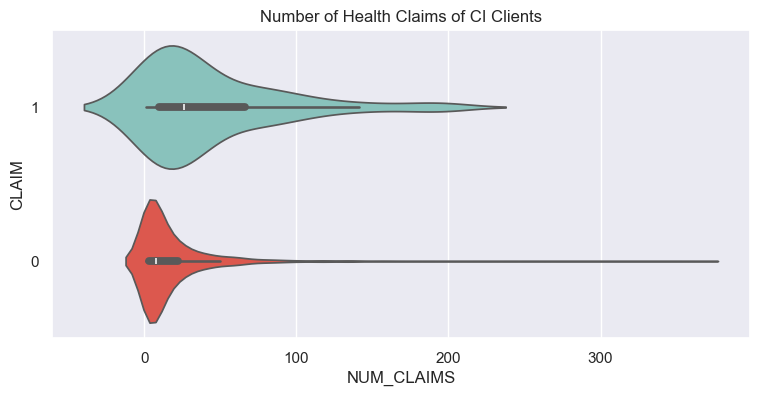

In [30]:
fig, ax = plt.subplots(figsize=(9,4))
pal={0:'#f44336', 1:'#80cbc4'}
sns.violinplot(data=df_mod, y="CLAIM", x="NUM_CLAIMS", order=[1,0], hue="CLAIM", orient='h', ax=ax, palette=pal)
ax.set_title('Number of Health Claims of CI Clients')
ax.get_legend().remove()
plt.show()

## Charges
Claimants appear to accumulate greater health charges.

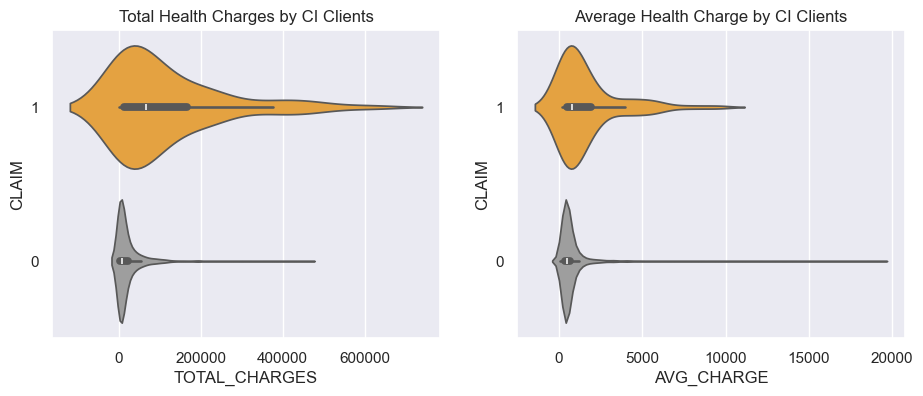

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,4))
pal={0:'#9e9e9e', 1:'#ffa726'}
sns.violinplot(data=df_mod, y="CLAIM", order=[1,0], x="TOTAL_CHARGES", hue="CLAIM", orient='h', ax=ax1, palette=pal)
ax1.set_title('Total Health Charges by CI Clients')
ax1.get_legend().remove()
sns.violinplot(data=df_mod, y="CLAIM", order=[1,0], x="AVG_CHARGE", hue="CLAIM", orient='h', ax=ax2, palette=pal)
ax2.set_title('Average Health Charge by CI Clients')
ax2.get_legend().remove()
plt.show()

## Procedure Groups
Claimants have higher counts of hospital, visit, vaccination, and vision procedures than nonclaimants.

In [32]:
procedure_groups = ['NUM_PROCEDURE_DENTAL', 'NUM_PROCEDURE_DRUGS', 'NUM_PROCEDURE_HOSPITAL', 'NUM_PROCEDURE_OTHER', 
                    'NUM_PROCEDURE_SERVICE', 'NUM_PROCEDURE_TEST', 'NUM_PROCEDURE_VACCINATION', 'NUM_PROCEDURE_VISION', 
                    'NUM_PROCEDURE_VISIT']

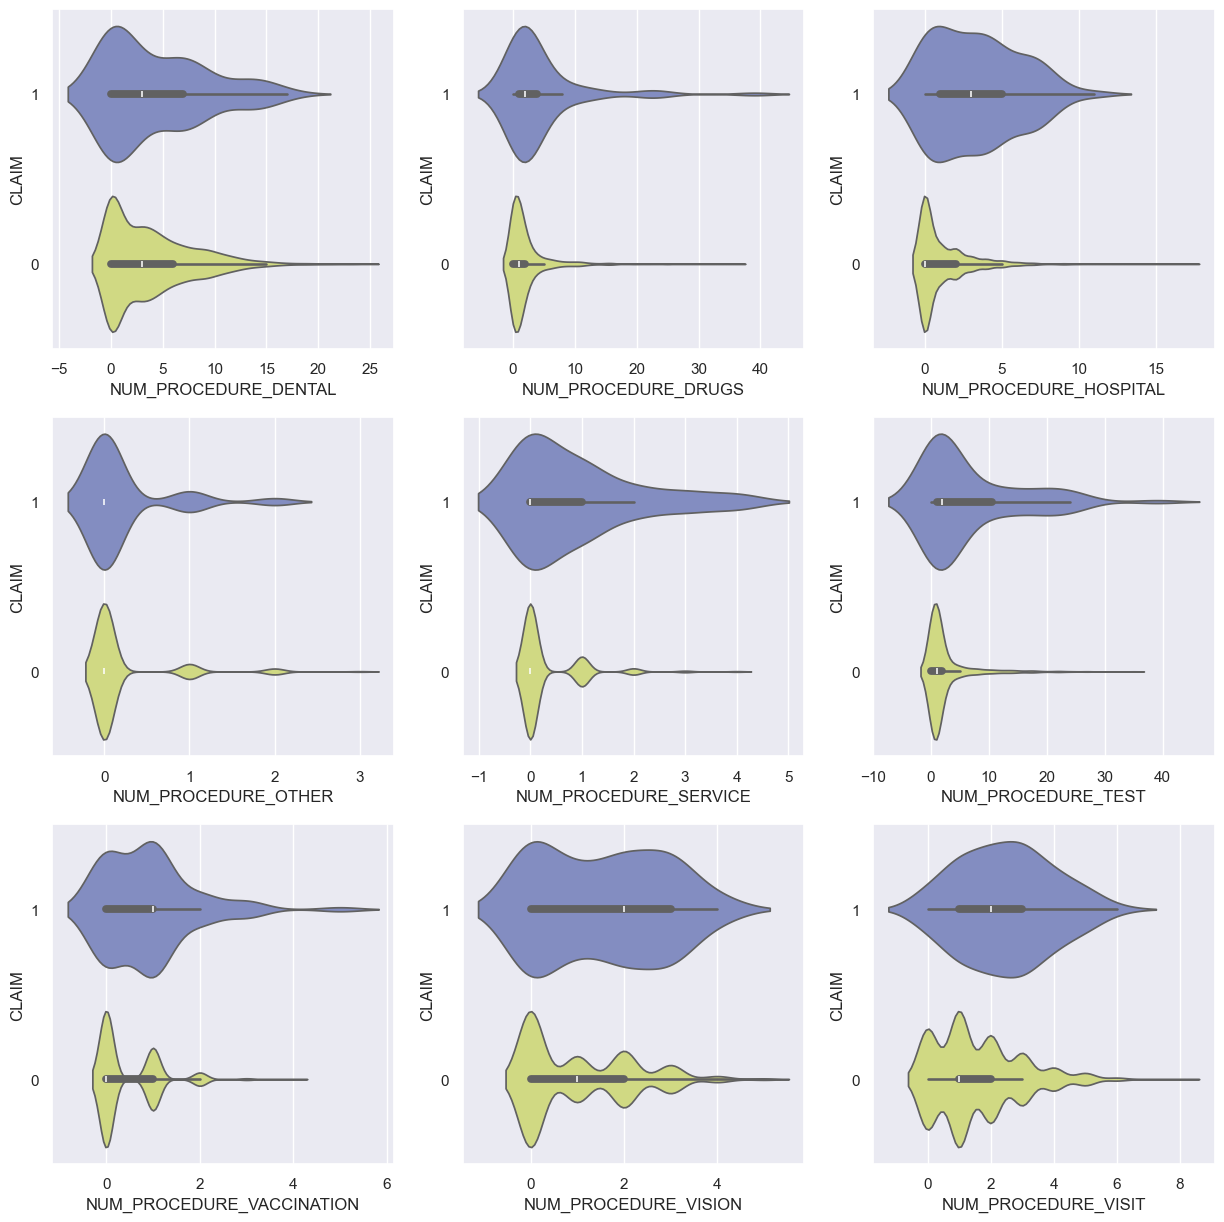

In [33]:
fig, ax = plt.subplots(3, 3, figsize=(15,15))
pal={1:'#7986cb', 0:'#dce775'}
i = j = 0
for pg in procedure_groups:
    sns.violinplot(data=df_mod, y="CLAIM", x=pg, order=[1,0], hue="CLAIM", orient='h', ax=ax[i][j], palette=pal)
    ax[i][j].get_legend().remove()
    j = j+1
    if j == 3:
        j = 0
        i = i + 1
plt.show()

## Diagnosis Groups
Claimants received more cancer, cardiac, chronic, common, exam, organ and other diagnoses than nonclaimants.

In [34]:
diagnosis_groups = ['NUM_DIAGNOSIS_CANCER', 'NUM_DIAGNOSIS_CARDIAC', 'NUM_DIAGNOSIS_CHRONIC', 'NUM_DIAGNOSIS_COMMON', 
                    'NUM_DIAGNOSIS_DENTAL', 'NUM_DIAGNOSIS_EXAM', 'NUM_DIAGNOSIS_INFECTION', 'NUM_DIAGNOSIS_INJURY', 
                    'NUM_DIAGNOSIS_ORGAN', 'NUM_DIAGNOSIS_OTHER', 'NUM_DIAGNOSIS_PAIN', 'NUM_DIAGNOSIS_RESPIRATORY', 
                    'NUM_DIAGNOSIS_SEXUAL', 'NUM_DIAGNOSIS_VISION']

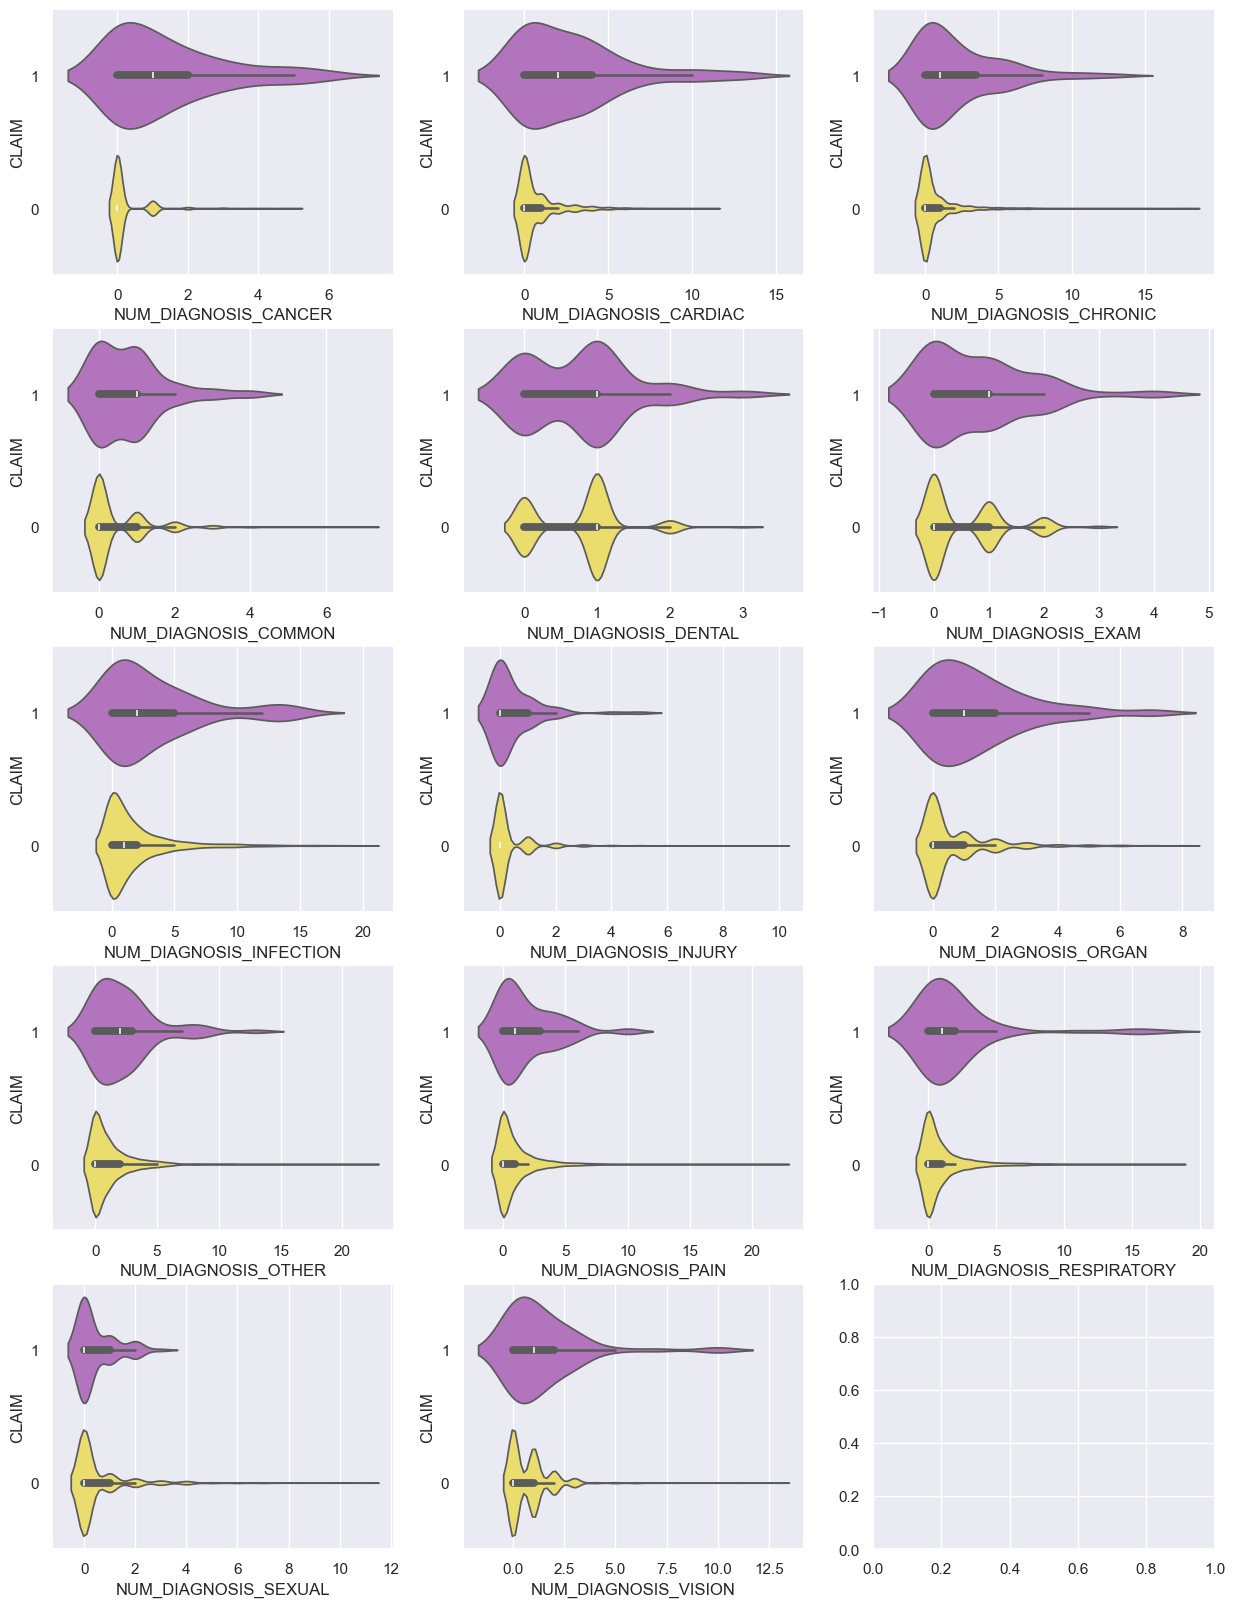

In [35]:
fig, ax = plt.subplots(5, 3, figsize=(15,20))
pal={0:'#ffee58', 1:'#ba68c8'}

i = j = 0
for dg in diagnosis_groups:
    sns.violinplot(data=df_mod, y="CLAIM", x=dg, order=[1,0], hue="CLAIM", orient='h', ax=ax[i][j], palette=pal)
    ax[i][j].get_legend().remove()
    j = j+1
    if j == 3:
        j = 0
        i = i + 1

plt.show()